In [ ]:
import json
import re
import sys
import pandas as pd
import numpy as np

In [ ]:
!pip install torch torchvision transformers

     |████████████████████████████████| 4.0 MB 32.5 MB/s 
     |████████████████████████████████| 77 kB 7.6 MB/s 
     |████████████████████████████████| 6.6 MB 62.4 MB/s 
     |████████████████████████████████| 880 kB 64.7 MB/s 
     |████████████████████████████████| 596 kB 61.9 MB/s 
     |████████████████████████████████| 96 kB 7.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.50-py3-none-any.whl size=895166 sha256=ccef10db7eb9cab00b0a5a3079900c781908bf170f4d2a5d2416b45565be71f3
  Stored in directory: /root/.cache/pip/wheels/d9/72/54/519f0d5143cc6c73fa3297509123c86fc8586a7fdea8d25311
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into 

In [ ]:
!pip install emoji

     |████████████████████████████████| 175 kB 27.1 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=6a64214b1b390b461555c34faea2439a4a10d43c5bbf81e12d9727954d3bd4c0
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


## Preprocessing

Load tweet data and perform preprocessing via `dataloader`

In [ ]:

train_df = pd.read_csv('train.csv')
dev_df = pd.read_csv('dev.csv')
test_df = pd.read_csv('test.csv')

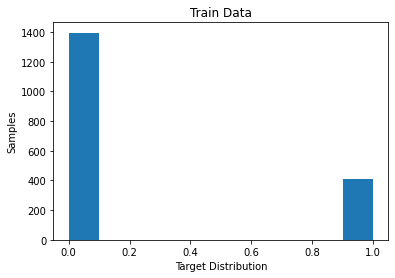

In [ ]:
import matplotlib.pyplot as plt
plt.title('Train Data')
plt.xlabel('Target Distribution')
plt.ylabel('Samples')
plt.hist(train_df.label)
plt.show()

In [ ]:
train_df

,Unnamed: 0,text,label,id
0,0,4. Can eating garlic help prevent infection wi...,0,1250219300389974016
1,1,French police chief killed himself after #Char...,1,554886875303780352
2,2,Coronavirus disease (COVID-19) advice for the ...,0,1237901309011021825
3,3,Ottawa police confirm that there were multiple...,0,524958128392376320
4,4,if the primary focus of a government isn't to ...,0,1239295488677085185
...,...,...,...,...
1802,1802,Desperate Ted Cruz Claims Planned Parenthood S...,1,671181758692507648
1803,1803,"""Thoughts and prayers are not enough."" Pres. O...",1,672513234419638273
1804,1804,Police have surrounded this building where the...,0,553508098825261056
1805,1805,@Kirstenjoyweiss @MattFabrication @prestone85 ...,0,1249479605582327808


In [ ]:
train_df['text'][5]

'10. Are hand dryers effective in killing the new coronavirus? https://t.co/cSDKXO1bGr 15. Drinking alcohol does not protect you against COVID-19 and can be dangerous https://t.co/ZrLN61q046 16. Being able to hold your breath for 10 seconds or more without coughing or feeling discomfort DOES NOT mean you are free from the coronavirus disease (COVID-19) or any other lung disease. https://t.co/gPUL51Y2lx 17. You can recover from the coronavirus disease (COVID-19). Catching the new coronavirus DOES NOT mean you will have it for life. https://t.co/yrjUM5qniK 18. Exposing yourself to the sun or to temperatures higher than 25C degrees DOES NOT prevent the coronavirus disease (COVID-19) https://t.co/aOQKrrwaBv 19. 5G mobile networks DO NOT spread COVID-19 https://t.co/VjqelBmpTn'

## Loading BertTokenizer

Load tokenizer from BERT

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import tensorflow as tf 

## BERT encoding

Data is encoded according to BERT requirement.

1. Tokenize the text
2. Add [CLS] and [SEP] token
3. Pad the sentences to sequence length of 512

In [ ]:
def bert_encode(data, maximum_sequence_length) :
    input_ids = []
    attention_masks = []


    for i in range(len(data.text)):
        encoded = tokenizer.encode_plus(
            data.text[i],
            add_special_tokens=True,
            max_length=maximum_sequence_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation = True
        )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

The input to BERT are two numpy arrays:

1) input_ids : list of token ids to be fed to a model

2) attention_masks: list of indices specifying which tokens should be attended to by the model.The input sequences are denoted by 1 and the padded ones by 0. These masks help to differentiate between the two.

## Create custom BERT Model

This BERT mdoel uses  TFBertModel with a dense layer and sigmoid activation.

In [ ]:
# Define f1 metric
# Code from https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
from keras import backend as K

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

    
def f1(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    return 2*((precision_value*recall_value) / (precision_value+recall_value+K.epsilon()))

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    input_ids = tf.keras.Input(shape=(512,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(512,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)

    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1])
    return model

In [ ]:
from transformers import TFBertModel

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# TFBertModel for local development

This BERT model was used for development purposes and makes use of the validation set to evaluate the performance on the given task.

In [ ]:
train_input_ids,train_attention_masks = bert_encode(train_df,512)
dev_input_ids,dev_attention_masks = bert_encode(dev_df,512)
test_input_ids,test_attention_masks = bert_encode(test_df,512)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Training

Fit for 7 epochs:

In [ ]:
validation_data = ([dev_input_ids, dev_attention_masks], dev_df.label)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
epochs = 7
batch_size = 4

In [ ]:
history = model.fit([train_input_ids,train_attention_masks], train_df.label, validation_data=validation_data ,callbacks=[callback], epochs=epochs, batch_size=batch_size)

Epoch 1/7
452/452 [==============================] - 264s 547ms/step - loss: 0.4570 - accuracy: 0.7676 - recall: 0.1687 - precision: 0.1901 - f1: 0.1659 - val_loss: 0.3353 - val_accuracy: 0.8471 - val_recall: 0.5794 - val_precision: 0.5168 - val_f1: 0.5329
Epoch 2/7
452/452 [==============================] - 246s 544ms/step - loss: 0.2576 - accuracy: 0.8993 - recall: 0.5028 - precision: 0.4980 - f1: 0.4884 - val_loss: 0.2204 - val_accuracy: 0.9311 - val_recall: 0.5884 - val_precision: 0.5884 - val_f1: 0.5805
Epoch 3/7
452/452 [==============================] - 246s 545ms/step - loss: 0.1446 - accuracy: 0.9607 - recall: 0.6073 - precision: 0.5999 - f1: 0.5965 - val_loss: 0.2515 - val_accuracy: 0.9176 - val_recall: 0.4776 - val_precision: 0.5224 - val_f1: 0.4893
Epoch 4/7
452/452 [==============================] - 246s 545ms/step - loss: 0.0857 - accuracy: 0.9795 - recall: 0.6042 - precision: 0.6077 - f1: 0.6031 - val_loss: 0.1829 - val_accuracy: 0.9395 - val_recall: 0.6040 - val_precisi

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

f1 = history.history['f1']
val_f1 = history.history['val_f1']

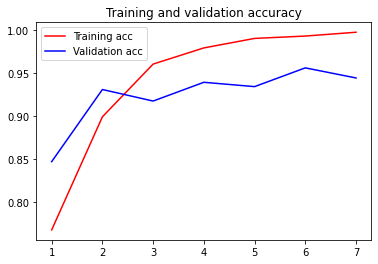

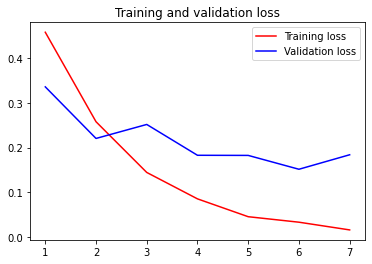

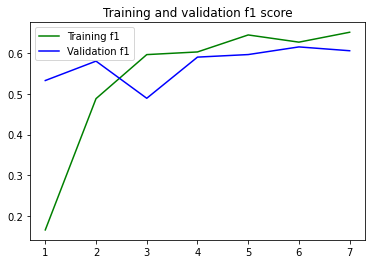

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', color = "red", label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', color="red", label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, f1, 'b', color = "green", label='Training f1')
plt.plot(epochs, val_f1, 'b', label='Validation f1')
plt.title('Training and validation f1 score')
plt.legend()

plt.show()

In [ ]:
model.save("./pure_bert/pure_bert_v11")

INFO:tensorflow:Assets written to: ./pure_bert/pure_bert_v11/assets


INFO:tensorflow:Assets written to: ./pure_bert/pure_bert_v11/assets


## Inference

In [ ]:
result = model.predict([test_input_ids, test_attention_masks])
result = np.round(result).astype(int)
#pred_labels = np.argmax(result, axis = 1)

#predicted_labels = [dataloader.convert_prediction(pred) for pred in result]
#output = pd.DataFrame({'id':test_df.id,'target':predicted_labels})
#output

In [ ]:
#result

In [ ]:
with open('test.predictions.txt', 'w') as output:
  output.write('Id,Predicted\n')
  counter = 0
  for elem in list(result):
    for elem2 in list(elem):
      output.write(str(counter) + ',' + str(elem2)+'\n')
      counter+=1



######### 目前输出截止到这里

In [ ]:
output

In [ ]:
def convert_label(label):
    if label == "rumour":
        return 1
    elif label == "non-rumour":
        return 0
    else:
        raise Exception("label classes must be 'rumour' or 'non-rumour'")
        
        
def convert_prediction(pred):
    if pred == 1:
        return "rumour"
    elif pred == 0:
        return "nonrumour"
    else:
        raise Exception("prediction classes must be '0' or '1'")

In [ ]:
predicted_labels = [convert_prediction(pred) for pred in result]
output = pd.DataFrame({'id':test_df.id,'target':predicted_labels})
output

In [ ]:
output

In [ ]:
submission = pd.Series(output.target.values,index=output.id).to_dict()
with open('test-output_v11.json', 'w') as f:
    json.dump(submission, f)

# BERT model from Huggingface Hub for CodaLab competition

For the CodaLab compeition, the train and development dataset has been merged to increase the size of the training set.

In [ ]:
combined_df = train_df.append(dev_df, ignore_index = True)
combined_df

,id,text,retweet_count,favorite_count,question_mark,contains_url,number_urls,contains_media,statuses_count,listed_count,...,reputation_score_2,favourites_count,verified,geo_enabled,has_description,length_description,source_tweet,replies,hashtags,label
0,552800070199148544,how to respond to the murderous attack on char...,228,77,True,False,0,True,27923,185,...,0.908971,500,False,False,True,46,how to respond to the murderous attack on char...,[jews label anyone they do not like as anti se...,[imcharliehebdo],0
1,544388259359387648,you can not condemn an entire race nation or ...,352,252,False,False,0,False,745,2,...,0.413158,428,False,False,True,115,you can not condemn an entire race nation or ...,[how many times are we going to have the do n...,"[sydneysiege, sydneysiege, leftistluzer, sydne...",0
2,552805970536333314,attempts to extend blame for this to all musli...,876,400,False,False,0,False,74137,1431,...,0.954630,6423,False,True,True,149,attempts to extend blame for this to all musli...,[when will we see mass protests from amoderat...,"[charliehebdo, nonmuslimlivesmatter]",0
3,525071376084791297,rest in peace cpl nathan cirillo killed tod...,112,96,False,True,1,True,28103,418,...,0.933548,2140,True,True,True,157,rest in peace cpl nathan cirillo killed tod...,"[hot guy, hey frizz i was right downtown crazy...","[ottawashooting, ottawashooting, ottawashootin...",1
4,498355319979143168,people debating whether mikebrown shoplifted o...,802,298,False,False,0,False,55920,65,...,0.678947,25389,False,False,True,156,people debating whether mikebrown shoplifted o...,[yeah and shooting him times while not even...,"[mikebrown, ferguson, mikebrown, mikebrown, mi...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,525025279803424768,the soldier shot dead in wednesday is ottawa a...,119,36,False,False,0,True,88483,306,...,0.727071,1903,True,True,True,101,the soldier shot dead in wednesday is ottawa a...,"[my condolences go out to your family, that ...","[hamont, ottawashooting, notinvain]",1
5217,552784600502915072,charlie hebdo became well known for publishing...,202,41,False,False,0,False,15128,1657,...,0.948267,0,True,True,True,158,charlie hebdo became well known for publishing...,[i am muslim would you call me violent even ...,[islamphobiaatitsbest],0
5218,499696525808001024,we got through that is a sniper on top of a t...,432,55,False,True,1,False,61902,1627,...,0.982027,1163,False,True,True,159,we got through that is a sniper on top of a t...,[we got through that is a sniper on top of a ...,"[ferguson, ferguson, ferguson, responsiblejour...",0
5219,580320612155060224,last position of germanwings flight u at ...,3092,480,False,True,1,True,7991,2384,...,0.998276,1131,True,True,True,146,last position of germanwings flight u at ...,[where was the pilot how come he did not use ...,"[4u9525, 4u9525, 4u9525, 4u9525, 4u9525, 4u952...",1


In [ ]:
combined_input_ids,combined_attention_masks = bert_encode(combined_df,512)
test_input_ids,test_attention_masks = bert_encode(test_df,512)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Training

Fit for 7 epochs:

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
epochs = 7
batch_size = 4

In [ ]:
history = model.fit([combined_input_ids,combined_attention_masks],combined_df.label,validation_split=0,callbacks=[callback], epochs=epochs,batch_size=batch_size)

Epoch 1/7
1306/1306 [==============================] - 1215s 917ms/step - loss: 0.5511 - accuracy: 0.7157 - recall: 0.3364 - precision: 0.3670 - f1: 0.3318
Epoch 2/7
1306/1306 [==============================] - 1198s 917ms/step - loss: 0.3281 - accuracy: 0.8573 - recall: 0.6496 - precision: 0.6434 - f1: 0.6242
Epoch 3/7
1306/1306 [==============================] - 1198s 917ms/step - loss: 0.2103 - accuracy: 0.9158 - recall: 0.7516 - precision: 0.7381 - f1: 0.7317
Epoch 4/7
1306/1306 [==============================] - 1198s 917ms/step - loss: 0.1305 - accuracy: 0.9528 - recall: 0.7286 - precision: 0.7216 - f1: 0.7176
Epoch 5/7
1306/1306 [==============================] - 1198s 917ms/step - loss: 0.0714 - accuracy: 0.9764 - recall: 0.7915 - precision: 0.7898 - f1: 0.7862
Epoch 6/7
1306/1306 [==============================] - 1198s 917ms/step - loss: 0.0391 - accuracy: 0.9871 - recall: 0.7993 - precision: 0.8014 - f1: 0.7981
Epoch 7/7
1306/1306 [==============================] - 1198s 917

In [ ]:
model.save("./pure_bert/pure_bert_v38")

INFO:tensorflow:Assets written to: ./pure_bert/pure_bert_v38/assets


INFO:tensorflow:Assets written to: ./pure_bert/pure_bert_v38/assets


## Inference

In [ ]:
result = model.predict([test_input_ids,test_attention_masks])
result = np.round(result).astype(int)
predicted_labels = [dataloader.convert_prediction(pred) for pred in result]
output = pd.DataFrame({'id':test_df.id,'target':predicted_labels})
output

In [ ]:
submission = pd.Series(output.target.values,index=output.id).to_dict()
with open('test-output_v38.json', 'w') as f:
    json.dump(submission, f)